In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

Загрузим данные.

In [ ]:
filename = 'data_prepared.csv'
df = pd.read_csv(filename, sep=',')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Columns: 408 entries, income to city_Yamunanagar
dtypes: float64(1), int64(407)
memory usage: 784.4 MB


In [ ]:
df.head()

,income,age,experience,married,car_ownership,current_job_years,current_house_years,risk_flag,state_Andhra_Pradesh,state_Assam,...,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam,city_Warangal,city_Yamunanagar
0,1303835.0,23,3,1,0,3,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7574516.0,40,10,1,0,9,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3991815.0,66,4,0,0,4,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6256451.0,41,2,1,0,2,12,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5768871.0,47,10,1,0,3,11,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Визуализация данных

## Общие методы

### Визуализация отдельной колонки

Метод `draw_boxplot` будет рисовать один ящик с усами по заданным данным.

In [ ]:
def draw_boxplot(data, axes=None, **kwargs):
    sns.boxplot(x=data, ax=axes, **kwargs)

Метод `draw_pairplot` будет рисовать попарный график.

In [ ]:
def draw_pairplot(data, axes=None, **kwargs):
    sns.pairplot(data, **kwargs)

Метод `draw_bar` рисует распределение в зависимости от колонок.

In [ ]:
def draw_bar(data, axes=None, **kwargs):
    sns.barplot(x=data[0], y=data[1], ax=axes, **kwargs)

Метод `draw_kde` позволяет отрисовать одномерное или двумерное распределение, используя оценку плотности ядра. Иными словами, каждая точка - ядро, вес ядра вблизи ядра достаточно высок, убывает по мере увеличения расстояния. Нормализуется сумма весов ядер и суммируются графики. Получается данный график.

In [ ]:
def draw_kde(data, axes=None, **kwargs):
    sns.kdeplot(data, ax=axes, **kwargs)

Метод `draw_jointplot` рисует двумерные и одномерные распределения. Очень удобный метод для сравнивания пары колонок.

In [ ]:
def draw_jointplot(data, axes=None, **kwargs):
    sns.jointplot(data=data, **kwargs)

Самый обычный `scatter` график.

In [ ]:
def draw_scatter(data, axes=None, cols=[0, 1], **kwargs):
    if axes is None:
        plt.scatter(x=data[cols[0]], y=data[cols[1]], **kwargs)
    elif isinstance(data, pd.DataFrame):
        data.plot()
    else:
        axes.scatter(x=data[cols[0]], y=data[cols[1]], **kwargs)

Метод `draw_hist` рисует гистограмму распределения.

In [ ]:
def draw_hist(data, axes=None, **kwargs):
    sns.histplot(data=data, ax=axes, **kwargs)

### Визуализация нескольких колонок

Напишем метод `draw_subplots`, который будет визуализировать графики для колонок. Все лишние аргументы будем передавать в модель, рисующую отдельный график по данным.

In [ ]:
def draw_subplots(df, columns=[], type_graph=None, ncols=3, figsize=(20, 6),
                  labels=None, titles=None, **kwargs):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=[figsize[0], figsize[1]*nrows])
    axes = np.array(axes)
    axes = axes.reshape((-1,))
    if type_graph is None:
        type_graph = draw_boxplot
    if labels is None:
        def_label = [i for i in range(len(columns))]
        labels = [def_label, def_label]
    if titles is None:
        titles = columns
    for i, col in enumerate(columns):
        axes[i].set(xlabel=labels[0][i], ylabel=labels[1][i], title=titles[i])
        type_graph(df[col], axes[i], **kwargs)

## Анализ зависимостей в данных

Выделим колонки, которые не были изменены с помощью `pd.get_dummies`. В дальнейшем будем именовать их в данной работе оригинальными.

In [ ]:
orig_columns = ['age', 'experience', 'current_job_years', 'current_house_years',
              'income', 'married', 'car_ownership', 'risk_flag']

Посмотрим на описание признаков оригинальных колонок - их среднее, отклонение.

In [ ]:
df[orig_columns].describe()

,age,experience,current_job_years,current_house_years,income,married,car_ownership,risk_flag
count,252000.000000,252000.00000,252000.000000,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000
mean,49.794687,10.08469,6.279504,11.838877,5.001149e+06,0.914341,0.253992,0.123000
std,15.650991,5.50645,3.344938,1.333721,2.640751e+06,0.279860,0.435294,0.328438
min,21.000000,0.00000,0.000000,10.000000,1.031000e+04,0.000000,0.000000,0.000000
25%,38.000000,6.00000,4.000000,11.000000,2.945168e+06,1.000000,0.000000,0.000000
50%,49.000000,10.00000,6.000000,12.000000,5.001149e+06,1.000000,0.000000,0.000000
75%,62.000000,14.00000,8.000000,13.000000,7.018326e+06,1.000000,1.000000,0.000000
max,79.000000,20.00000,14.000000,14.000000,9.999938e+06,1.000000,1.000000,1.000000


Признак `income` имеет большой разброс данных и самое большее среднее.

Посмотрим на корелляцию признаков между собой. В качестве данных возьмем оригинальные признаки.

<AxesSubplot:>

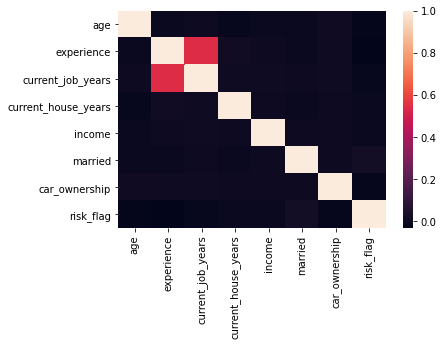

In [ ]:
sns.heatmap(df[orig_columns].corr())

In [ ]:
df[orig_columns].corr()

,age,experience,current_job_years,current_house_years,income,married,car_ownership,risk_flag
age,1.000000,-0.002021,0.001337,-0.016107,-0.001968,-0.005240,0.008418,-0.020922
experience,-0.002021,1.000000,0.542194,0.013883,0.003519,-0.001815,0.005621,-0.032749
current_job_years,0.001337,0.542194,1.000000,0.004155,0.006259,0.001757,0.006587,-0.015364
current_house_years,-0.016107,0.013883,0.004155,1.000000,0.000009,-0.006453,0.000840,-0.002834
income,-0.001968,0.003519,0.006259,0.000009,1.000000,0.003395,0.002922,-0.002937
married,-0.005240,-0.001815,0.001757,-0.006453,0.003395,1.000000,0.001488,0.018913
car_ownership,0.008418,0.005621,0.006587,0.000840,0.002922,0.001488,1.000000,-0.020644
risk_flag,-0.020922,-0.032749,-0.015364,-0.002834,-0.002937,0.018913,-0.020644,1.000000


Заметим, что `risk_flag` хуже всего кореллирует со всеми остальными данными. Это значит, что он будет слабо влиять на остальные данные и на него будут слабо влиять большинство из анализируемых данных. Однако, возможна задача бинарной классификации по этому признаку, поэтому не будем сильно спешить.

Посмотрим на распределение признаков - построим [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) - ящик с усами.

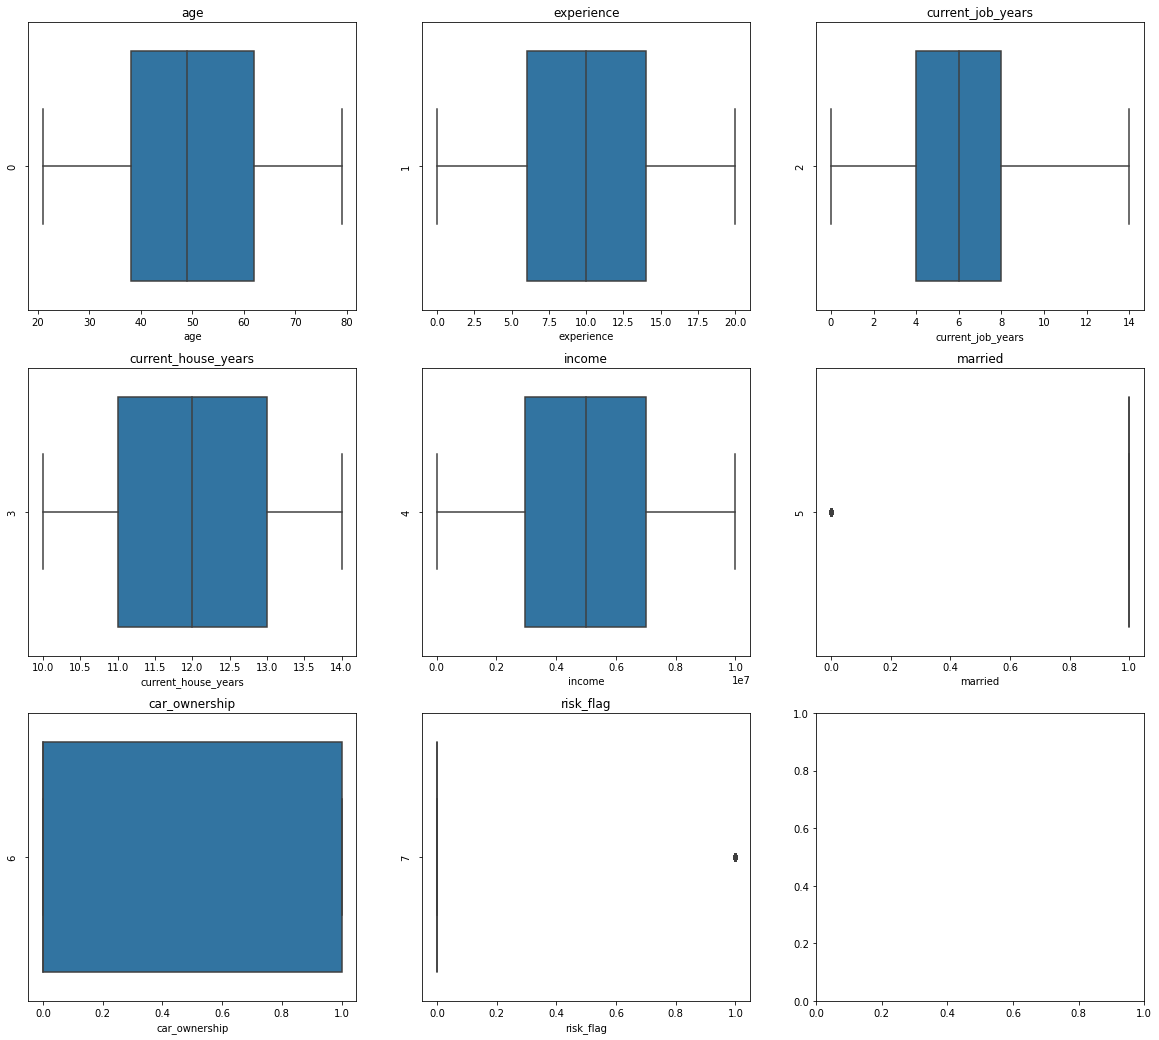

In [ ]:
draw_subplots(df, orig_columns)

Видим, что для колонок `married`, `risk_flag` распределение данных неравномерно - преобладает один из классов
- `married` - класс 1;
- `risk_flag` - класс 0.

Также заметим, что для всех остальных колонок выбросов не обнаружено - данные лежат в пределах $[\mu - 3 \sigma; \mu + 3 \sigma]$. Можно предположить, что они кореллируют с нормальным распределением $ N(\mu, \sigma)$.

Предобработка выбросов не требуется.

Выясним, какие колонки больше всего влияют на колонку `risk_flag`. Поскольку корелляция между данной колонкой и остальными основными минимальна, будем сравнивать со всеми колонками. Для этого воспользуемся линейной регрессией с регуляризацией L2. Данный вид регуляризации используется, чтобы отобрать неинформативные колонки от информативных. Воспользуемся моделью [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) из библиотеки sklearn.

In [ ]:
target = 'risk_flag'
X = df.drop(target, axis=1)
y = df[target]
model = Lasso()
model.fit(X, y)

Lasso()

Коэффициенты при модели находятся в поле `coef`.

In [ ]:
eps = 1e-10
np.sum(np.where(np.abs(model.coef_) - eps > 0, 1, 0))

1

Получили, что при параметре `alpha=1.0` присутствует всего 1 значащий параметр. Проведем подбор гиперпараметров.

Подбор параметров будем проводить с помощью [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) из библиотеки sklearn.

In [ ]:
params = {
    'alpha': [0.001, 0.01, 0.1, 0.5]
}

est = GridSearchCV(Lasso(), params)
%time est.fit(X, y)
print(est.best_params_)

Wall time: 45.6 s
{'alpha': 0.001}


Вновь посмотрим на коэффициенты модели для лучшего параметра `alpha`.

In [ ]:
eps = 1e-10
num_meaningful_params = np.sum(np.where(np.abs(est.best_estimator_.coef_) - eps > 0, 1, 0))
num_meaningful_params

11

In [ ]:
eps = 1e-6
num_meaningful_params = np.sum(np.where(np.abs(est.best_estimator_.coef_) - eps > 0, 1, 0))
num_meaningful_params

10

Получили уже 11 значащих параметров для `eps=1e-10` и 10 значащих параметров для `eps=1e-6`. В дальнейшем будем работать с `eps=1e-6`. Визуализируем эти параметры, также выведем их имена.

In [ ]:
df.columns[np.where(np.abs(est.best_estimator_.coef_) - eps > 0)]

Index(['age', 'experience', 'married', 'car_ownership', 'current_job_years',
       'current_house_years', 'state_Kerala', 'state_Sikkim',
       'house_ownership_norent_noown', 'house_ownership_owned'],
      dtype='object')

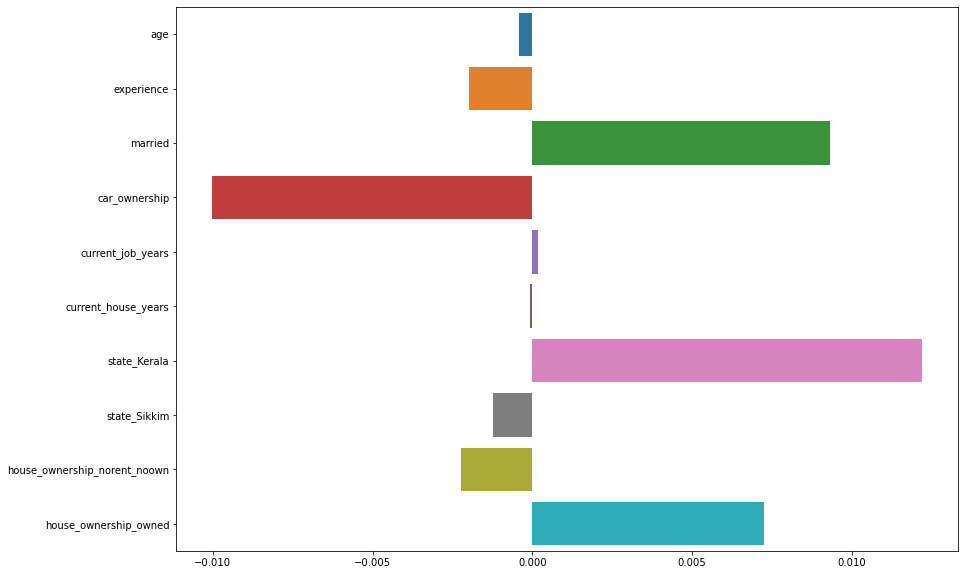

In [ ]:
fig, axes = plt.subplots(figsize=(14, 1*num_meaningful_params))
draw_bar([
    est.best_estimator_.coef_[np.where(np.abs(est.best_estimator_.coef_) - eps > 0)],
    df.columns[np.where(np.abs(est.best_estimator_.coef_) - eps > 0)]], orient='h')

Хотелось бы видеть распределение по модулю - чтобы посмотреть соотношение. Сделаем распределение по модулю.

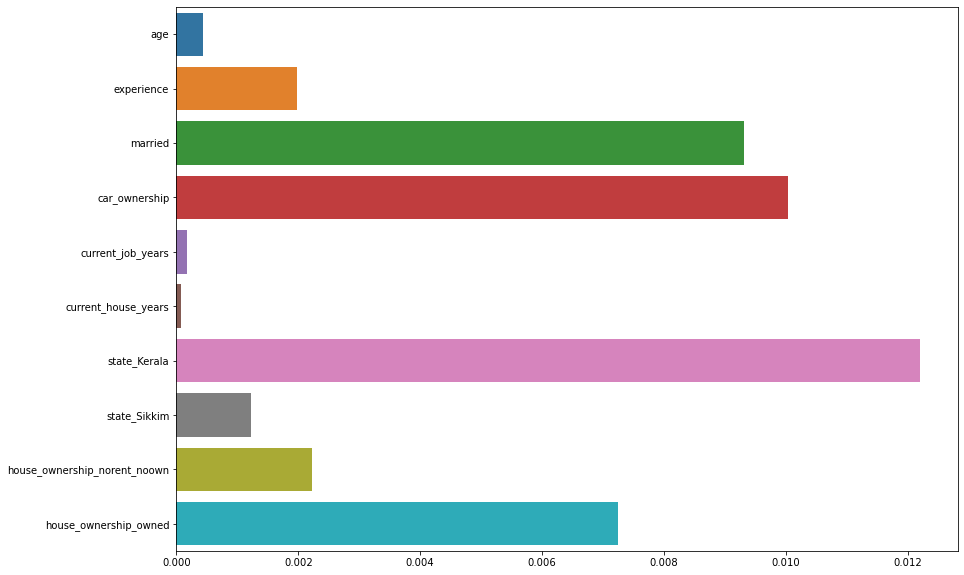

In [ ]:
fig, axes = plt.subplots(figsize=(14, 1*num_meaningful_params))
draw_bar([
    np.abs(est.best_estimator_.coef_)[np.where(np.abs(est.best_estimator_.coef_) - eps > 0)],
    df.columns[np.where(np.abs(est.best_estimator_.coef_) - eps > 0)]], orient='h')

Видим, что наибольшее влияние оказывают колонки `state_Kerala`, `car_ownership`, `married`, `house_ownership_owned`. Поэтому если дадут задачу предсказания данной колонки, тогда будем использовать только эти 11 информативных колонок.

## Визуализирование зависимостей данных

Нарисуем гистограммы распределения оригинальных данных.

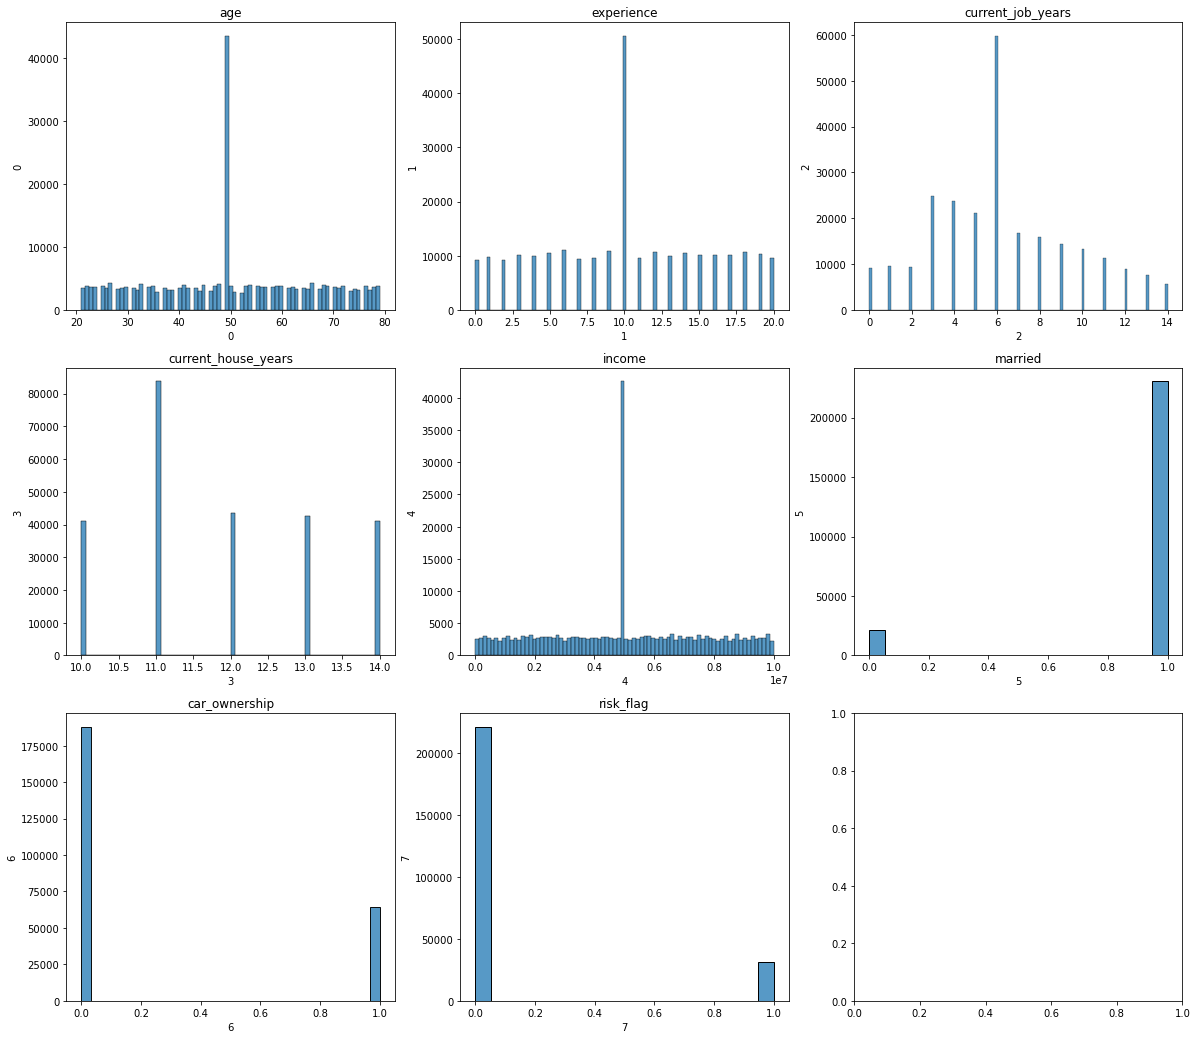

In [ ]:
draw_subplots(df, columns=orig_columns, type_graph=draw_hist)

В колонках `age`, `experience`, `income`, `current_house_years` распределение данных близко к равномерному.

В колонках `married`, `car_ownership`, `risk_flag` наблюдается дисбаланс классов - в дальнейшем это может плохо повлиять на обучение модели.

Проведем попарную визуализацию данных с помощью [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html). Не будем смотреть на бинарные признаки - визуализируем их отдельно.

In [ ]:
pairs = [['age', 'experience'],
         ['current_job_years', 'current_house_years'],
         ['age', 'income'], ]
titles = [p[0] + ' - ' + p[1] for p in pairs]

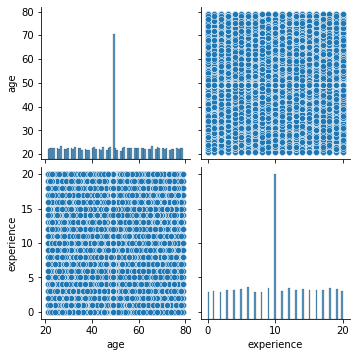

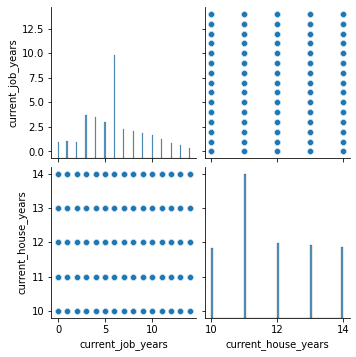

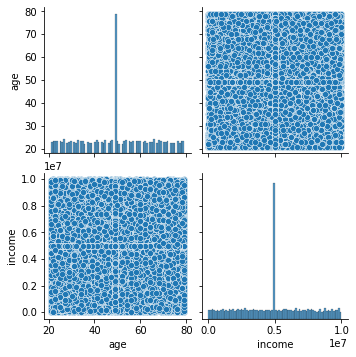

In [ ]:
for pair in pairs:
    draw_pairplot(df[pair])

Видим, что данные распределены равномерно, отсутствуют какие-либо видимые зависимости между данными. Большое число значений в центре гистограмм возникает из-за заполнения пропусков колонок средними значениями.

Визуализируем зависимости для всех оригинальных признаков.

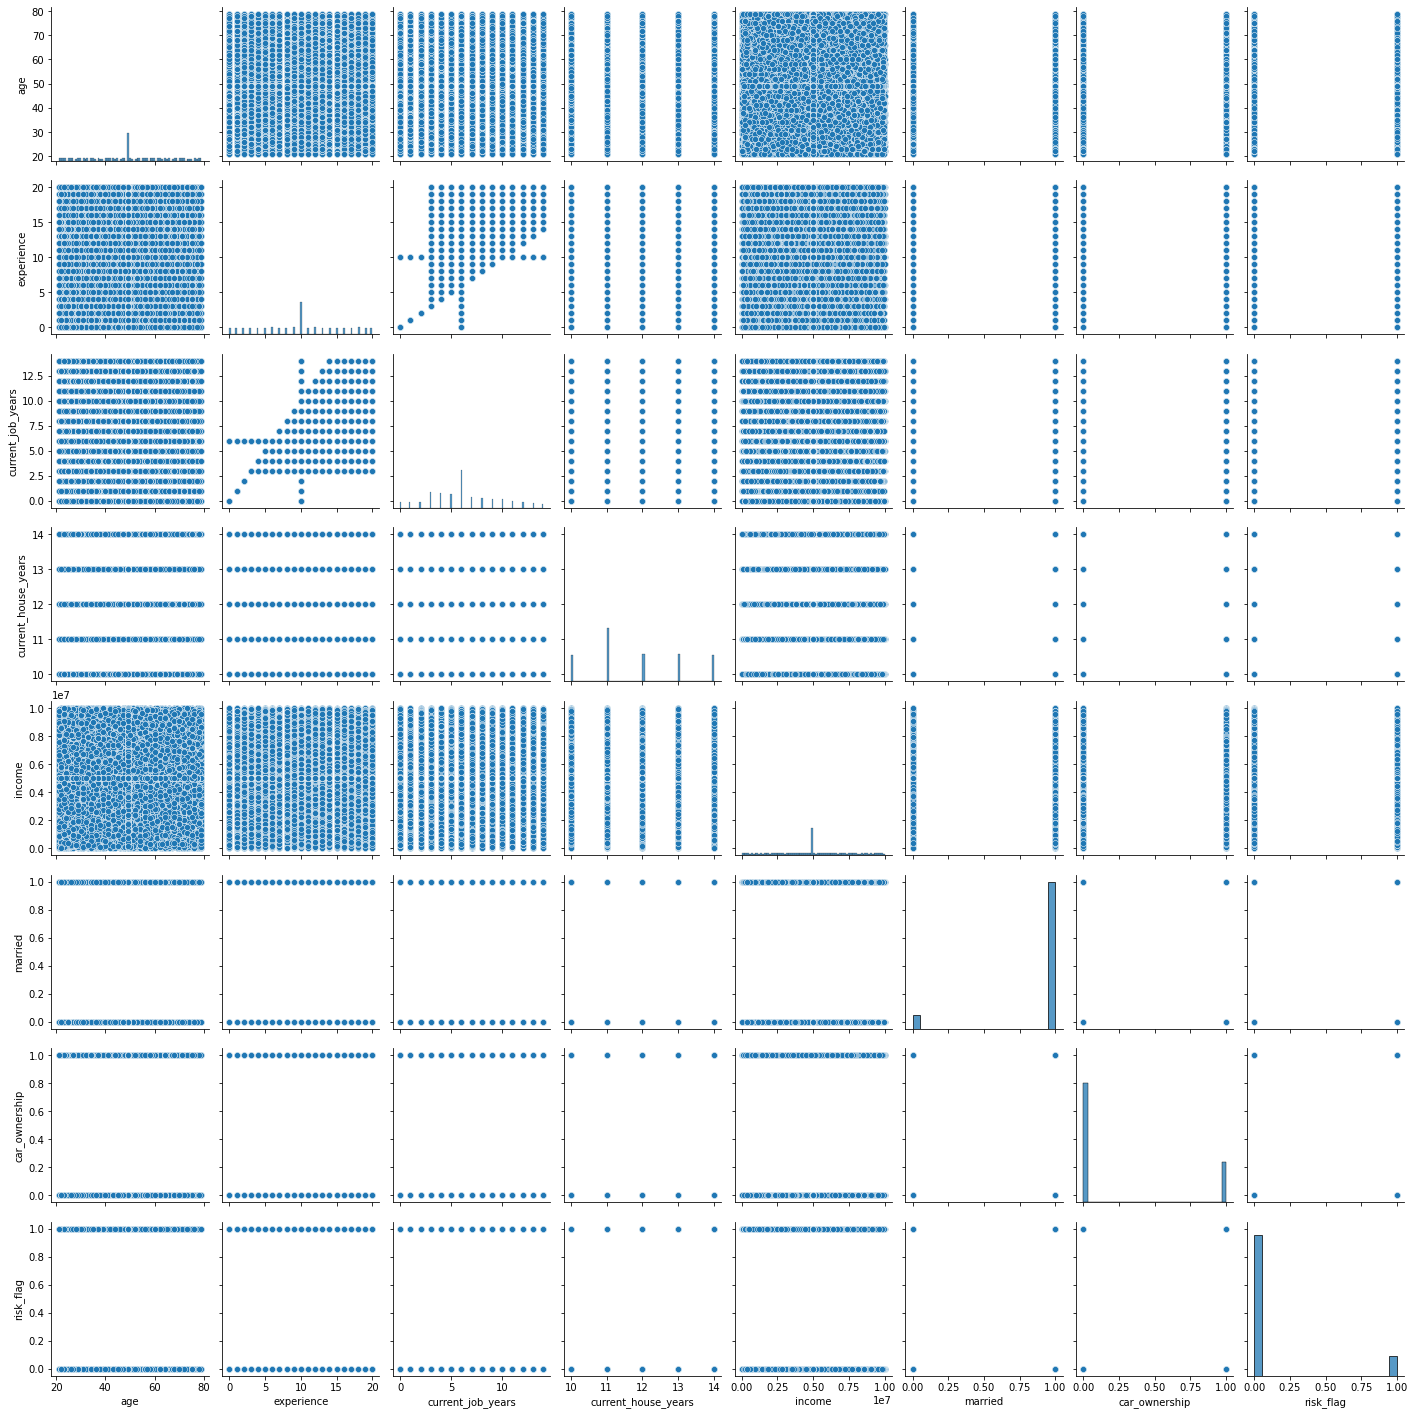

In [ ]:
sns.pairplot(df[orig_columns])

Видим, что все данные распределены более-менее равномерно, имеется дисбаланс классов в колонке `married`.

Более детально посмотрим на распределение пар
- `age` - `income`;
- `experience` - `current_job_years`.
Используем `joinplot`.

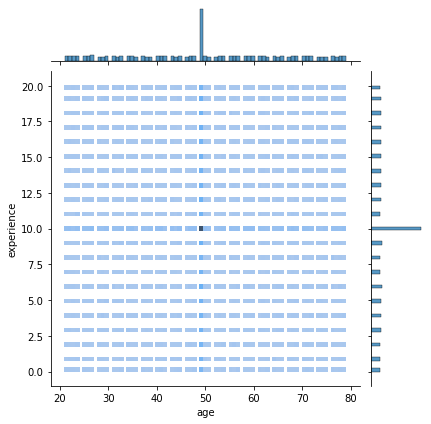

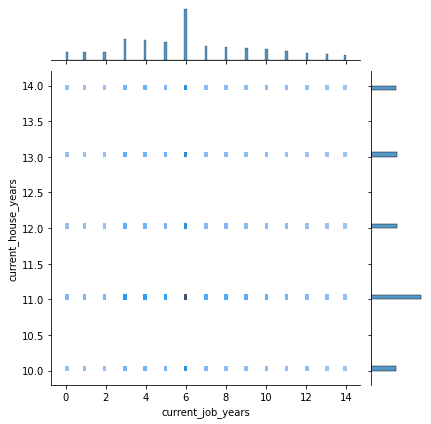

In [ ]:
pair = [['age', 'income'],
    ['experience', 'current_job_years']]
kinds = ['hist', 'hist']
for kind, pair in zip(kinds, pairs):
    draw_jointplot(data=df[pair], x=pair[0], y=pair[1], kind=kind)

Действительно, значения распределены более-менее равномерно. Основная масса значений находится на их среднем (`mean`).

Рассмотрим подробнее гистограммы распределения признаков с большим числом разброса значений.

In [ ]:
many_vals = ['age', 'income', 'experience']

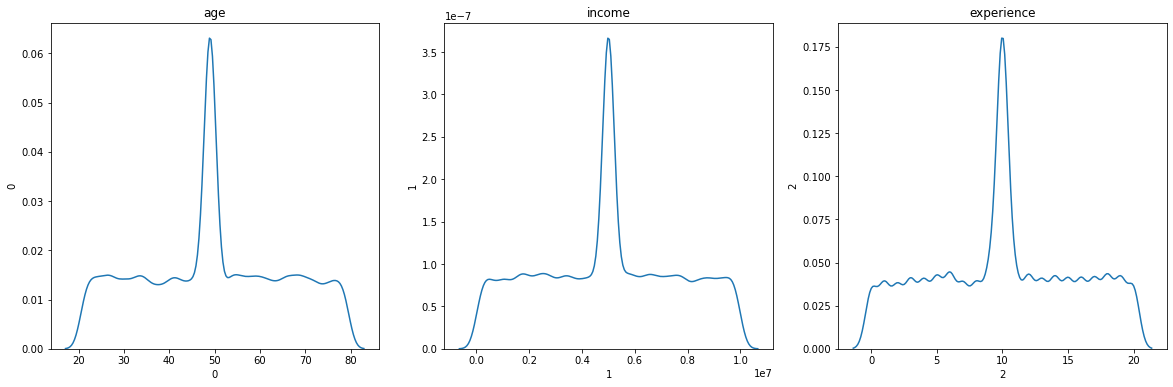

In [ ]:
draw_subplots(df, columns=many_vals, type_graph=draw_kde)

Логично, что большая часть ядер концентрируется около среднего - это видно по заполнению пропусков. Однако, можно сказать, что ядра распределены более-менее равномерно.

Попробуем сгруппировать по признаку `current_house_years` и посмотреть, что получится.

risk_flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

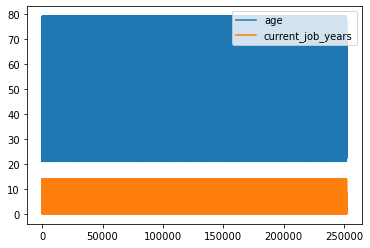

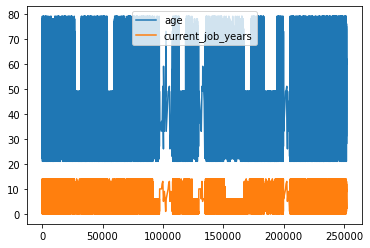

In [ ]:
df[['age', 'current_job_years', 'risk_flag']].groupby('risk_flag')[['age', 'current_job_years']].plot()

Достаточно интересное распределение получилось - видим, что в метке `risk_flag=1` имеются ощутимые пробелы в некоторых областях `age` и `current_job_years`. Скорее всего это возникло из-за дисбалансов классов, так как в классе 0 присутствуют все значения и визуально не видно пробелов. Это подтверждается в графике `boxplot` выше.